<a href="https://colab.research.google.com/github/realfolkcode/GraphRegression/blob/master/label_propagation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and Install

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import r2_score
import scipy
from scipy.sparse.linalg import cg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pip install gpytorch

     |████████████████████████████████| 310 kB 34.2 MB/s 
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509889 sha256=80c20e103eb3422eb4c4aecb7832c978d2110c5a2ce8839756660a43bf2cb97c
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
Successfully built gpytorch


In [3]:
from gpytorch.utils import linear_cg

In [4]:
!git clone https://github.com/realfolkcode/GraphRegression.git

Cloning into 'GraphRegression'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 140 (delta 54), reused 90 (delta 25), pack-reused 0
Receiving objects: 100% (140/140), 371.68 KiB | 634.00 KiB/s, done.
Resolving deltas: 100% (54/54), done.


In [5]:
from GraphRegression.utils import load_jj_data, set_random_seeds

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
RANDOM_SEED = 0

# Process Data

In [7]:
path = "GraphRegression/data/county/election/2012"
adj, X, y, idx_train, idx_val, idx_test = load_jj_data(path)
idx_train_val = torch.cat((idx_train, idx_val))
y = y.reshape(-1, 1)

print("adj:", adj.shape)
print("features:", X.shape)
print("labels:", y.shape)
print("idx_train:", idx_train.shape)
print("idx_val:", idx_val.shape)
print("idx_test:", idx_test.shape)

adj: torch.Size([3234, 3234])
features: torch.Size([3234, 6])
labels: torch.Size([3234, 1])
idx_train: torch.Size([1941])
idx_val: torch.Size([646])
idx_test: torch.Size([647])


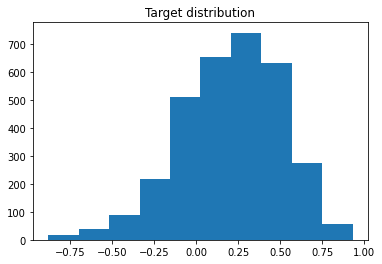

In [8]:
plt.hist(y.flatten())
plt.title('Target distribution')
plt.show()

# MLP

In [9]:
class MLP(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(n_in, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
        )
        self.regressor = nn.Linear(16, 1)
    
    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x

In [10]:
def epoch_train(model, loader, criterion, opt):
    train_loss = 0
    model.train()
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        loss = criterion(output, target)
        opt.zero_grad()
        loss.backward()
        opt.step()
        train_loss += loss.item()
    train_loss /= len(loader)
    return train_loss

In [11]:
def epoch_val(model, loader, criterion):
    val_loss = 0
    target_lst = []
    output_lst = []
    model.eval()
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            target_lst += target.tolist()
            output_lst += output.tolist()
            val_loss = criterion(output, target).item()
    r2 = r2_score(target_lst, output_lst)
    val_loss /= len(loader)
    return val_loss, r2

In [12]:
set_random_seeds(seed_value=RANDOM_SEED, device=device)

mlp = MLP(6).to(device)

In [13]:
criterion = nn.MSELoss()
opt = torch.optim.Adam(mlp.parameters())

In [14]:
batch_size = 128

train_loader = DataLoader(TensorDataset(X[idx_train], y[idx_train]), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X[idx_val], y[idx_val]), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X[idx_test], y[idx_test]), batch_size=batch_size, shuffle=False)

In [15]:
num_epochs = 75

train_loss = []
val_loss = []
val_r2 = []
test_loss = []
test_r2 = []

best_r2 = 0
best_epoch = 0

for i in tqdm(range(num_epochs)):
    loss = epoch_train(mlp, train_loader, criterion, opt)
    train_loss.append(np.sqrt(loss))

    loss, r2 = epoch_val(mlp, val_loader, criterion)
    val_loss.append(np.sqrt(loss))
    val_r2.append(r2)
    if r2 > best_r2:
        best_epoch = i
        best_r2 = r2


    loss, r2 = epoch_val(mlp, test_loader, criterion)
    test_loss.append(np.sqrt(loss))
    test_r2.append(r2)
    print('---------------------------------------------------------')
    print(f'Epoch: {i}, Val R2: {val_r2[-1]}, Test R2: {test_r2[-1]}')

  3%|▎         | 2/75 [00:00<00:14,  5.13it/s]

---------------------------------------------------------
Epoch: 0, Val R2: -0.0026882756293522547, Test R2: 0.045387934859565604
---------------------------------------------------------
Epoch: 1, Val R2: 0.09440017095376008, Test R2: 0.1455411269728646


  5%|▌         | 4/75 [00:00<00:17,  4.09it/s]

---------------------------------------------------------
Epoch: 2, Val R2: 0.15563058009933228, Test R2: 0.20056630234672712
---------------------------------------------------------
Epoch: 3, Val R2: 0.2006995847728017, Test R2: 0.2413663287999519


  8%|▊         | 6/75 [00:01<00:13,  4.94it/s]

---------------------------------------------------------
Epoch: 4, Val R2: 0.22912843056832333, Test R2: 0.26253141660298496
---------------------------------------------------------
Epoch: 5, Val R2: 0.25388043088888346, Test R2: 0.27942908950855194


  9%|▉         | 7/75 [00:01<00:13,  5.00it/s]

---------------------------------------------------------
Epoch: 6, Val R2: 0.2676683859168808, Test R2: 0.2903053357887936


 12%|█▏        | 9/75 [00:01<00:12,  5.33it/s]

---------------------------------------------------------
Epoch: 7, Val R2: 0.28137437380784425, Test R2: 0.29466272222698564
---------------------------------------------------------
Epoch: 8, Val R2: 0.2887310873522524, Test R2: 0.2989290459828666


 15%|█▍        | 11/75 [00:02<00:11,  5.36it/s]

---------------------------------------------------------
Epoch: 9, Val R2: 0.2937925812306573, Test R2: 0.30239812104260355
---------------------------------------------------------
Epoch: 10, Val R2: 0.29770634209339764, Test R2: 0.30371856198422154


 17%|█▋        | 13/75 [00:02<00:10,  5.65it/s]

---------------------------------------------------------
Epoch: 11, Val R2: 0.30190180630655605, Test R2: 0.3070781877493185
---------------------------------------------------------
Epoch: 12, Val R2: 0.3126500519616936, Test R2: 0.31604538470159893


 20%|██        | 15/75 [00:02<00:09,  6.03it/s]

---------------------------------------------------------
Epoch: 13, Val R2: 0.31258470951164363, Test R2: 0.31299526677419875
---------------------------------------------------------
Epoch: 14, Val R2: 0.3185120534927043, Test R2: 0.3220455052770427


 21%|██▏       | 16/75 [00:03<00:09,  6.47it/s]

---------------------------------------------------------
Epoch: 15, Val R2: 0.3230206144378095, Test R2: 0.3272451607354284


 24%|██▍       | 18/75 [00:03<00:09,  6.08it/s]

---------------------------------------------------------
Epoch: 16, Val R2: 0.32491928397668834, Test R2: 0.3282551879917712
---------------------------------------------------------
Epoch: 17, Val R2: 0.32773575717134007, Test R2: 0.3303356063850408


 27%|██▋       | 20/75 [00:03<00:09,  6.04it/s]

---------------------------------------------------------
Epoch: 18, Val R2: 0.330978241624289, Test R2: 0.33102771986876667
---------------------------------------------------------
Epoch: 19, Val R2: 0.33668049118301413, Test R2: 0.33683947005713555


 28%|██▊       | 21/75 [00:03<00:09,  5.74it/s]

---------------------------------------------------------
Epoch: 20, Val R2: 0.3367852738472896, Test R2: 0.33149987284055427


 31%|███       | 23/75 [00:04<00:09,  5.44it/s]

---------------------------------------------------------
Epoch: 21, Val R2: 0.3399087624899888, Test R2: 0.33696073966328
---------------------------------------------------------
Epoch: 22, Val R2: 0.3450030084067809, Test R2: 0.3448767929326363


 33%|███▎      | 25/75 [00:04<00:08,  5.86it/s]

---------------------------------------------------------
Epoch: 23, Val R2: 0.344720222724497, Test R2: 0.342485183725053
---------------------------------------------------------
Epoch: 24, Val R2: 0.35101033850167573, Test R2: 0.34777775335956773


 36%|███▌      | 27/75 [00:04<00:07,  6.37it/s]

---------------------------------------------------------
Epoch: 25, Val R2: 0.3517254654420514, Test R2: 0.34879655543079313
---------------------------------------------------------
Epoch: 26, Val R2: 0.3510262266849914, Test R2: 0.3478599824231856


 39%|███▊      | 29/75 [00:05<00:07,  5.91it/s]

---------------------------------------------------------
Epoch: 27, Val R2: 0.3536784044659389, Test R2: 0.3519651678521938
---------------------------------------------------------
Epoch: 28, Val R2: 0.3570539507385091, Test R2: 0.35556110472968905


 41%|████▏     | 31/75 [00:05<00:07,  5.69it/s]

---------------------------------------------------------
Epoch: 29, Val R2: 0.3572595636922782, Test R2: 0.3577333209757326
---------------------------------------------------------
Epoch: 30, Val R2: 0.3595321909952929, Test R2: 0.3591631755197269


 44%|████▍     | 33/75 [00:05<00:07,  5.98it/s]

---------------------------------------------------------
Epoch: 31, Val R2: 0.3613820526985082, Test R2: 0.3590167872827319
---------------------------------------------------------
Epoch: 32, Val R2: 0.3622028874107417, Test R2: 0.3608911451535465


 47%|████▋     | 35/75 [00:06<00:07,  5.57it/s]

---------------------------------------------------------
Epoch: 33, Val R2: 0.3646436591356005, Test R2: 0.36788060443366444
---------------------------------------------------------
Epoch: 34, Val R2: 0.3630242610674401, Test R2: 0.35910806185201205


 49%|████▉     | 37/75 [00:06<00:06,  6.03it/s]

---------------------------------------------------------
Epoch: 35, Val R2: 0.3663832355707467, Test R2: 0.36469278027663266
---------------------------------------------------------
Epoch: 36, Val R2: 0.36716276020660077, Test R2: 0.3646664992360603


 52%|█████▏    | 39/75 [00:06<00:06,  5.88it/s]

---------------------------------------------------------
Epoch: 37, Val R2: 0.36697420787782753, Test R2: 0.3648610152919902
---------------------------------------------------------
Epoch: 38, Val R2: 0.3700632065903897, Test R2: 0.372582029507843


 53%|█████▎    | 40/75 [00:07<00:05,  5.84it/s]

---------------------------------------------------------
Epoch: 39, Val R2: 0.3690342163121856, Test R2: 0.3663410313230848


 56%|█████▌    | 42/75 [00:07<00:05,  5.59it/s]

---------------------------------------------------------
Epoch: 40, Val R2: 0.36915818584752824, Test R2: 0.3678914661878021
---------------------------------------------------------
Epoch: 41, Val R2: 0.36929177931477875, Test R2: 0.3718282149499491


 59%|█████▊    | 44/75 [00:07<00:05,  5.67it/s]

---------------------------------------------------------
Epoch: 42, Val R2: 0.37057195908914775, Test R2: 0.3716350200573598
---------------------------------------------------------
Epoch: 43, Val R2: 0.37183717493500734, Test R2: 0.373907953936488


 61%|██████▏   | 46/75 [00:08<00:04,  5.83it/s]

---------------------------------------------------------
Epoch: 44, Val R2: 0.376447371424689, Test R2: 0.37802154785189923
---------------------------------------------------------
Epoch: 45, Val R2: 0.3738072478553154, Test R2: 0.3722640500197938


 64%|██████▍   | 48/75 [00:08<00:04,  6.31it/s]

---------------------------------------------------------
Epoch: 46, Val R2: 0.3763536829725703, Test R2: 0.3754212878640869
---------------------------------------------------------
Epoch: 47, Val R2: 0.37538202747495586, Test R2: 0.3706552257112641


 67%|██████▋   | 50/75 [00:08<00:03,  6.42it/s]

---------------------------------------------------------
Epoch: 48, Val R2: 0.3770842219033944, Test R2: 0.37710534093472514
---------------------------------------------------------
Epoch: 49, Val R2: 0.3753401326650446, Test R2: 0.3727783778069318


 69%|██████▉   | 52/75 [00:09<00:03,  6.08it/s]

---------------------------------------------------------
Epoch: 50, Val R2: 0.3755761765568423, Test R2: 0.37833826458524555
---------------------------------------------------------
Epoch: 51, Val R2: 0.3776718194579526, Test R2: 0.3790356278571839


 72%|███████▏  | 54/75 [00:09<00:03,  6.43it/s]

---------------------------------------------------------
Epoch: 52, Val R2: 0.37497250427014206, Test R2: 0.37352402277728747
---------------------------------------------------------
Epoch: 53, Val R2: 0.37894734369211047, Test R2: 0.38116765852799483


 75%|███████▍  | 56/75 [00:09<00:02,  6.70it/s]

---------------------------------------------------------
Epoch: 54, Val R2: 0.37589821385678124, Test R2: 0.3749358643348656
---------------------------------------------------------
Epoch: 55, Val R2: 0.3805650679334789, Test R2: 0.3822606099319631


 77%|███████▋  | 58/75 [00:10<00:02,  6.36it/s]

---------------------------------------------------------
Epoch: 56, Val R2: 0.3795071950868607, Test R2: 0.3837378717008266
---------------------------------------------------------
Epoch: 57, Val R2: 0.379286400113206, Test R2: 0.37451440703531846


 81%|████████▏ | 61/75 [00:10<00:01,  8.10it/s]

---------------------------------------------------------
Epoch: 58, Val R2: 0.37889167510322597, Test R2: 0.3817358622639131
---------------------------------------------------------
Epoch: 59, Val R2: 0.3831978485593165, Test R2: 0.38077055050528485
---------------------------------------------------------
Epoch: 60, Val R2: 0.38575867614290715, Test R2: 0.38721055059588627


 85%|████████▌ | 64/75 [00:10<00:01,  8.74it/s]

---------------------------------------------------------
Epoch: 61, Val R2: 0.3817924674166693, Test R2: 0.38241310947658136
---------------------------------------------------------
Epoch: 62, Val R2: 0.3824064885820634, Test R2: 0.3805741627038751
---------------------------------------------------------
Epoch: 63, Val R2: 0.38310216752443305, Test R2: 0.3807807239558898


 88%|████████▊ | 66/75 [00:10<00:01,  8.27it/s]

---------------------------------------------------------
Epoch: 64, Val R2: 0.38337242062303967, Test R2: 0.385752482424941
---------------------------------------------------------
Epoch: 65, Val R2: 0.3850411733276744, Test R2: 0.37993199942825495


 91%|█████████ | 68/75 [00:11<00:00,  7.33it/s]

---------------------------------------------------------
Epoch: 66, Val R2: 0.38588959735979744, Test R2: 0.378221022317492
---------------------------------------------------------
Epoch: 67, Val R2: 0.38777721579242874, Test R2: 0.387815967772998


 97%|█████████▋| 73/75 [00:11<00:00, 12.89it/s]

---------------------------------------------------------
Epoch: 68, Val R2: 0.3847987467477889, Test R2: 0.3744442115684026
---------------------------------------------------------
Epoch: 69, Val R2: 0.38805215873295706, Test R2: 0.3865021906542442
---------------------------------------------------------
Epoch: 70, Val R2: 0.3849472529021034, Test R2: 0.37887936561990343
---------------------------------------------------------
Epoch: 71, Val R2: 0.386840141394558, Test R2: 0.38265061253559907
---------------------------------------------------------
Epoch: 72, Val R2: 0.3843009509700376, Test R2: 0.38780481971826697


100%|██████████| 75/75 [00:11<00:00,  6.45it/s]

---------------------------------------------------------
Epoch: 73, Val R2: 0.3813674238687301, Test R2: 0.38319146146332583
---------------------------------------------------------
Epoch: 74, Val R2: 0.385774371074625, Test R2: 0.3867318476931504


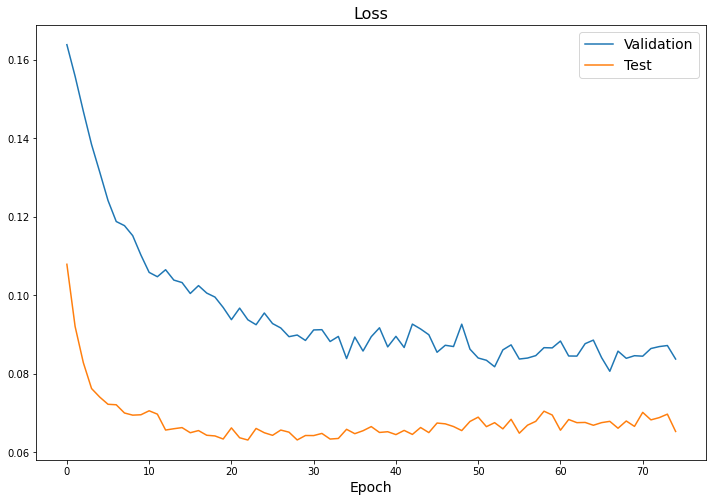

In [16]:
plt.figure(figsize=(12,8))
plt.plot(val_loss, label='Validation')
plt.plot(test_loss, label='Test')
plt.legend(fontsize=14)
plt.title('Loss', size=16)
plt.xlabel('Epoch', size=14)
plt.show()

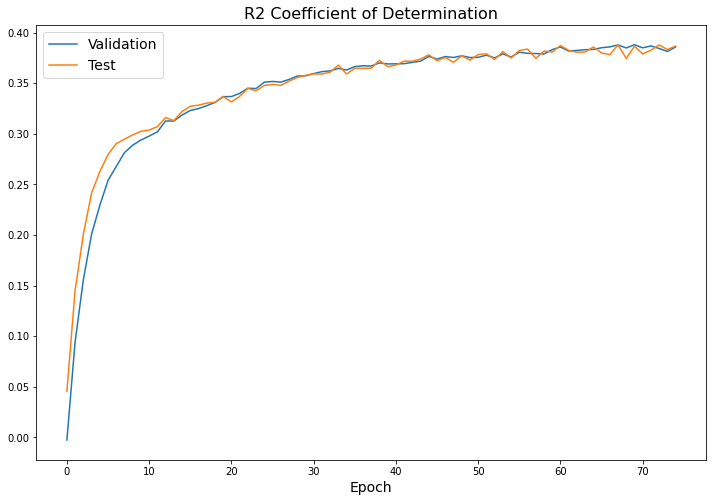

In [17]:
plt.figure(figsize=(12,8))
plt.plot(val_r2, label='Validation')
plt.plot(test_r2, label='Test')
plt.legend(fontsize=14)
plt.title('R2 Coefficient of Determination', size=16)
plt.xlabel('Epoch', size=14)
plt.show()

In [18]:
print('Best epoch:', best_epoch)

Best epoch: 69


In [19]:
set_random_seeds(seed_value=RANDOM_SEED, device=device)

mlp = MLP(6).to(device)
criterion = nn.MSELoss()
opt = torch.optim.Adam(mlp.parameters())

In [20]:
train_val_loader = DataLoader(TensorDataset(X[idx_train_val], y[idx_train_val]), batch_size=batch_size, shuffle=True)

In [21]:
for i in tqdm(range(best_epoch)):
    loss = epoch_train(mlp, train_val_loader, criterion, opt)

loss, r2 = epoch_val(mlp, test_loader, criterion)
print(f'Epoch: {best_epoch}, Test R2: {r2}')

100%|██████████| 69/69 [00:03<00:00, 22.91it/s]

Epoch: 69, Test R2: 0.3928638308391693


In [108]:
with torch.no_grad():
    pred_train_val = mlp(X[idx_train_val].to(device)).cpu()
    pred_test = mlp(X[idx_test].to(device)).cpu()

# Label Propagation

## GPyTorch CG

In [101]:
def label_propagation(adj, y_train, idx_train, idx_test, pred_train=None, pred_test=None):
    '''
    Attributes
    ----------
    adj: torch.sparse.FloatTensor
        normalized adjacency matrix
    '''
    L = torch.eye(len(adj)) - adj
    res_test = torch.zeros(len(idx_test), 1)
    if pred_train is None:
        res_train = y_train
    else:
        res_train = y_train - pred_train
    A = L[idx_test, :][:, idx_test]
    b = -L[idx_test, :][:, idx_train] @ res_train
    res_test = linear_cg(A, b)
    if pred_test is None:
        z = res_test
    else:
        z = pred_test + res_test
    return z

In [102]:
%timeit label_propagation(adj, y[idx_train_val], idx_train_val, idx_test)

10 loops, best of 5: 40 ms per loop


In [103]:
z = label_propagation(adj, y[idx_train_val], idx_train_val, idx_test)

In [104]:
r2_score(z, y[idx_test])

0.41428293947116124

## SciPy CG

In [125]:
def label_propagation_scipy(adj, y_train, idx_train, idx_test, pred_train=None, pred_test=None):
    '''
    Attributes
    ----------
    adj: scipy.sparse
        normalized adjacency matrix
    '''
    L = scipy.sparse.eye(adj.shape[0]) - adj
    z = np.zeros((len(idx_test), 1))
    if pred_train is None:
        res_train = y_train
    else:
        res_train = y_train - pred_train
    A = L[idx_test, :][:, idx_test]
    b = -L[idx_test, :][:, idx_train] @ res_train
    res_test = cg(A, b)[0].reshape(-1, 1)
    if pred_test is None:
        z = res_test
    else:
        z = pred_test + res_test
    return z

In [112]:
adj_sp = scipy.sparse.csr_matrix(adj.to_dense())

In [113]:
%timeit label_propagation_scipy(adj_sp, y[idx_train_val].numpy(), idx_train_val.numpy(), idx_test.numpy())

100 loops, best of 5: 2.02 ms per loop


In [114]:
z = label_propagation_scipy(adj_sp, y[idx_train_val].numpy(), idx_train_val.numpy(), idx_test.numpy())

In [115]:
r2_score(z, y[idx_test])

0.41428299093056464

# LP-MLP

In [109]:
z = label_propagation(adj, y[idx_train_val], idx_train_val, idx_test, pred_train_val, pred_test)

In [110]:
r2_score(z, y[idx_test])

0.573937922641211

In [126]:
z = label_propagation_scipy(adj_sp, y[idx_train_val], idx_train_val, idx_test, pred_train_val, pred_test)

In [127]:
r2_score(z, y[idx_test])

0.5739369018726643